In [1]:
import pandas as pd
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 
import sweetviz as sv
from datetime import datetime
# from pyts.decomposition import SingularSpectrumAnalysis

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, Flatten,Dropout,Input,GRU,concatenate
from tensorflow.keras import layers
from keras.layers import TimeDistributed
import keras.backend as K
from argparse import ArgumentParser
from keras.callbacks import EarlyStopping



import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'archive\artificialWithAnomaly\artificialWithAnomaly\art_daily_jumpsup.csv')


In [3]:
df

,timestamp,value
0,2014-04-01 00:00:00,19.761252
1,2014-04-01 00:05:00,20.500833
2,2014-04-01 00:10:00,19.961641
3,2014-04-01 00:15:00,21.490266
4,2014-04-01 00:20:00,20.187739
...,...,...
4027,2014-04-14 23:35:00,18.074649
4028,2014-04-14 23:40:00,21.002014
4029,2014-04-14 23:45:00,20.566713
4030,2014-04-14 23:50:00,18.254193


In [4]:
date = df["timestamp"]

In [5]:
df.drop("timestamp", axis =1 ,inplace =True)

In [6]:
for col in df.columns:
    if len(df[col].value_counts()) <50:
        df.drop(col, axis = 1 , inplace = True)
    elif not np.issubdtype(df[col].dtype, np.number):
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [7]:
imputer = KNNImputer(n_neighbors=5)
knn = imputer.fit(df)
df=pd.DataFrame(knn.transform(df),columns=df.columns)
# df.dropna(inplace=True)

In [8]:
df['Date'] = date

In [9]:
df.isna().sum()

value    0
Date     0
dtype: int64

In [11]:
df.to_csv("save.csv")
df= pd.read_csv("save.csv",parse_dates=['Date'], index_col="Date")
df.drop('Unnamed: 0',axis =1 ,inplace= True)

In [12]:
df

,value
Date,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


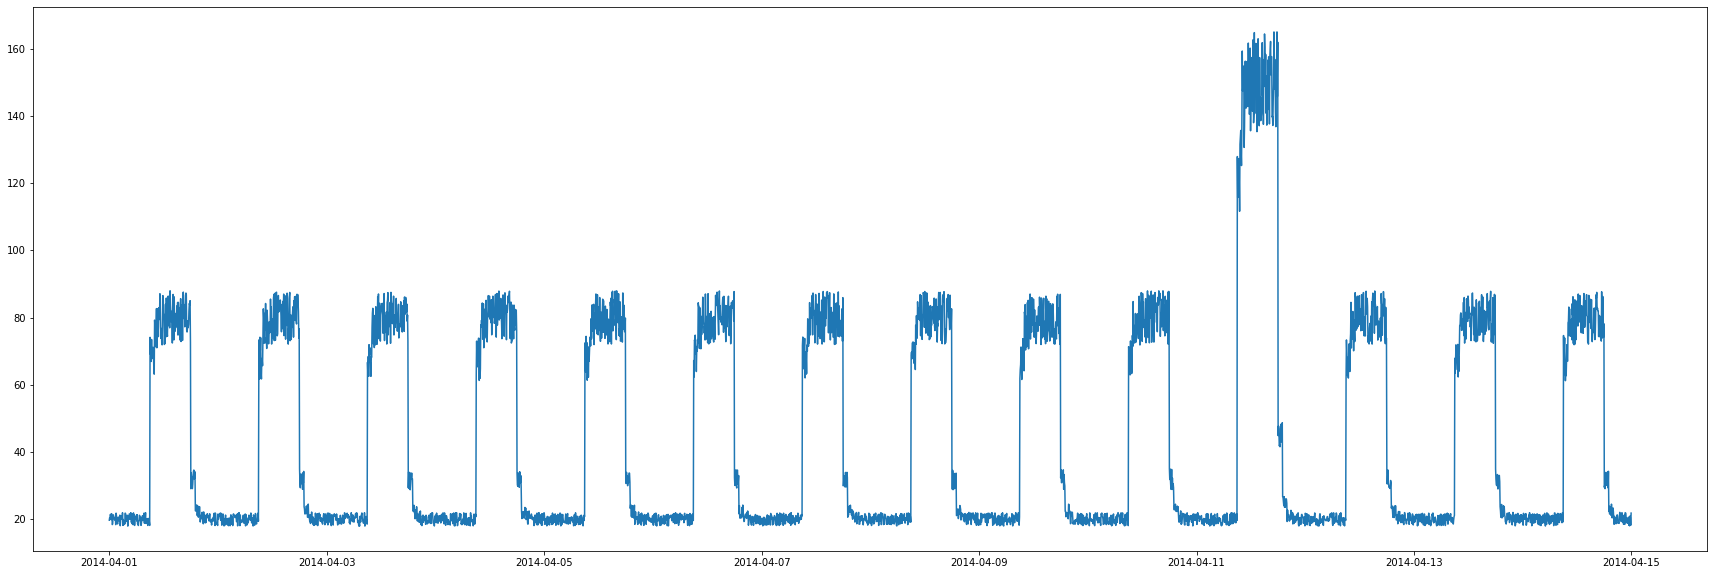

In [13]:
plt.figure(figsize=(30,10))
plt.plot(df)

In [14]:
def data_engineering(df,col):
    # train_size =int(len(df)*0.5)
    train, test = df,df#df.iloc[0:train_size],df.iloc[train_size:len(df)]

    scaler = StandardScaler()
    scaler = scaler.fit(train[[col]])
    train[col]= scaler.transform(train[[col]])
    test[col]= scaler.transform(test[[col]])
    # print(train.head())
    return train,test,scaler

In [15]:
def create_dataset(X,y,time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
def train_test_split(train,test,TIME_STEPS,col):
    x_train,y_train = create_dataset(train[[col]],train[col],TIME_STEPS)
    x_test,y_test = create_dataset(test[[col]],test[col],TIME_STEPS)
    return x_train,x_test,y_train,y_test

In [17]:
def get_model(x_train):
    model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
    # model.summary()
    return model
  

In [18]:
def visualization2(train_mse_loss,axs):

    sns.distplot(train_mse_loss,bins=50,kde=True,ax = axs)

In [19]:

def visualization3(test_score_df,axs):
    sns.lineplot(x= test_score_df.index, y= test_score_df.loss,label='loss',ax = axs)
    sns.lineplot(x = test_score_df.index, y =test_score_df.threshold,label='threshold',ax = axs)
   

In [21]:
def visualization4(test,threshold,TIME_STEPS,ax,test_mae_loss):
    test_mae_loss = test_mae_loss.reshape((-1))
    anomalies = test_mae_loss > threshold
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    anomalous_data_indices = []
    for data_idx in range(TIME_STEPS - 1, len(test) - TIME_STEPS + 1):
        if np.all(anomalies[data_idx - int(TIME_STEPS/2) + 1 ]):
            anomalous_data_indices.append(data_idx)
    df_subset = test.iloc[anomalous_data_indices]
    test.plot(legend=False, ax=ax)
    df_subset.plot(legend=False, ax=ax, color="r")

In [22]:
df

,value
Date,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 timesteps per day
288 * 14 = 4032 data points in total

START value
1 value
(3744, 288, 1) (3744, 288, 1) (3744,) (3744,)
2 value
Epoch 1/50
30/30 [==============================] - 2s 14ms/step - loss: 0.7534
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.1667
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.1284
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.1072
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0932
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0827
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0745
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0695
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0642
Epoch 10/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0608
Epoch 11/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0574
Epoch 12/50
30/30 [=========================

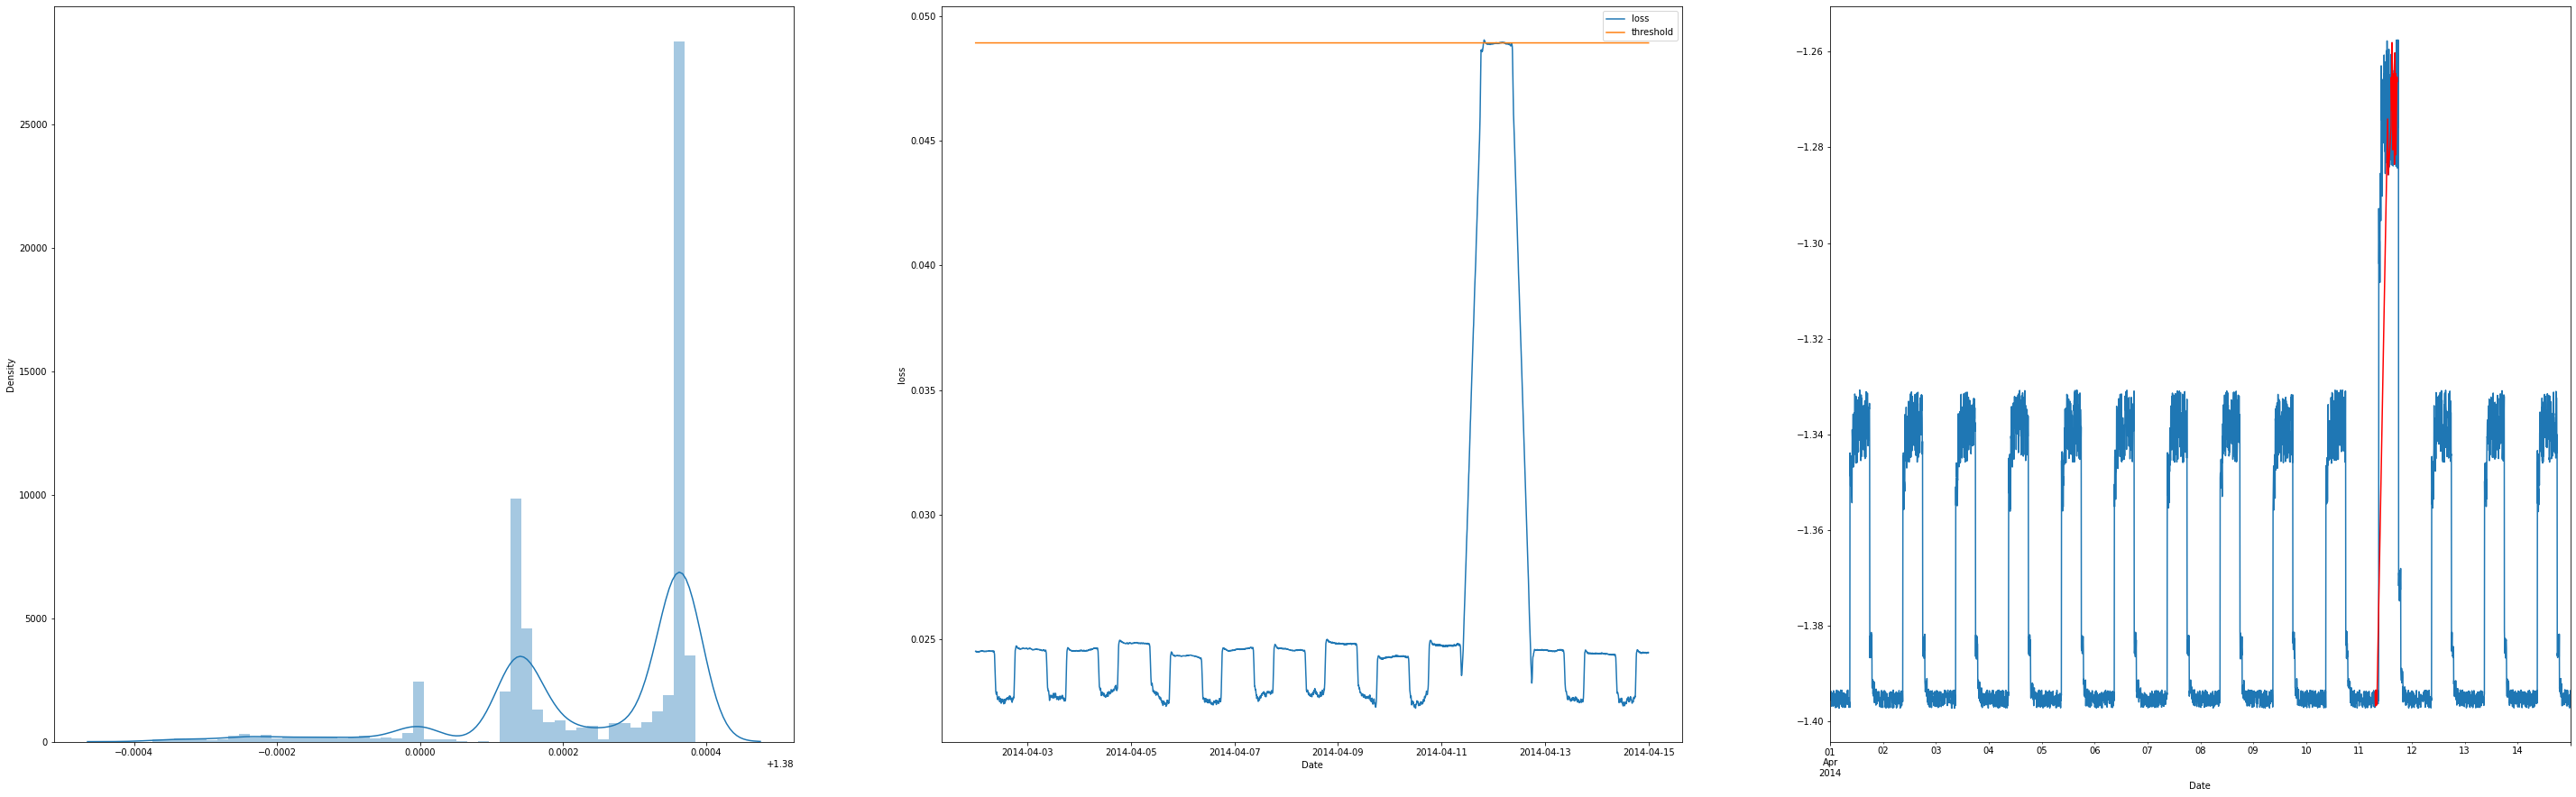

In [23]:
TIME_STEPS = 288#needs to be configed to the right jumps 
anomaly= []
ig,axs=plt.subplots(df.shape[1],3,figsize=(50,15))
axs = axs.ravel()
i=0
for col in df.columns:
    print("START",col)
    final = df[[col]]
    train,test,scaler = data_engineering(final,col)
    print(1,col)

    x_train,x_test,y_train,y_test = train_test_split(train,test,TIME_STEPS,col)
    print(x_train.shape, x_test.shape,y_train.shape,y_test.shape)
    print(2,col)

    model = get_model(x_train)
    history = model.fit(x_train,y_train, epochs =50, batch_size=128,shuffle = False,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1, restore_best_weights = True)])
    print(3,col)

    x_train_pred = model.predict(x_train)
    train_mse_loss=np.mean(np.abs(x_train_pred,x_train),axis=1)
    x_test_pred = model.predict(x_test)
    visualization2(train_mse_loss,axs[i])
    i+=1
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    THRESHOLD = np.percentile(test_mae_loss, 99)
    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[col] = test[TIME_STEPS:][col]
    anomalies = test_score_df[test_score_df.anomaly == True]
    anomaly.append(test_score_df[test_score_df.anomaly == True])
    anomalies.head()
    visualization3(test_score_df,axs[i])
    i+=1
    print(4,col)
    visualization4(test,THRESHOLD,TIME_STEPS,axs[i],test_mae_loss)
    # visualization4(test,anomalies,TIME_STEPS,scaler,axs[i],col)
    i+=1
    print('Finish',col)


In [24]:
df.loc[anomaly[0].index].mean() 


value    20.897166
dtype: float64

In [25]:
df.mean() 

value    44.494254
dtype: float64